In [1]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
from scipy import interpolate, special


####Some definitions##
v2 = 246.**2 
mh=125
v=246
alpha=1/137 #fine structure constant
sinthw=np.sqrt(0.223) #sine of Weinberg angle
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2)) ## U(1)_Y gauge coupling constant
g=np.sqrt(4*np.pi*alpha)/sinthw #SU(2)_L gauge coupling constant
Mplanck=2.4*10**18 #reduced planck mass
cs=1/3**0.5 ##Sound speed constant

###Experimental data for fermion masses and mixing angles, taken from past project
mu=2.3*10**(-3)
deltamu=0.6*10**(-3)
mc=1.275
deltamc=0.025
mt=160
deltamt=4.5
md=4.8*10**(-3)
deltamd=0.4*10**(-3)
ms=95*10**(-3)
deltams=5*10**(-3)
mb=4.18
deltamb=0.03
me=5.11*10**(-4)
deltame=5.11*10**(-6)
mmu=0.106
deltammu=0.106*10**(-2)
mtau=1.78
deltamtau=1.78*10**(-2)
Vus=0.225
deltaVus=0.225*10**(-2)
Vub=3.55*10**(-3)
deltaVub=0.15*10**(-3)
Vcb=4.14*10**(-2)
deltaVcb=1.2*10**(-3)


In [23]:
#nQ=(3,2,0)
#nu=(3,2,0)
#nd=(1,0,0)

nQ=(3,2,0)
nu=(3,2,0)
nd=(2,1,1)

#nQ=(2,1,0)
#nu=(5,2,0)
#nd=(5,4,2)


def Yukawa_mat(yij,nQ,nq,epsilon):
    """Generic Yukawa matrix given numerical coefficients, U(1) charges and 
    ratio of flavon vev to flavor scale.
    --------------
    parameters
    yij: array obj, matrix of coeffcients. Expected to be order 1 as the couplings decend down from the UV
    nQ: tuple, generic charges of left handed quark (or lepton) doublet
    nq: tuple, generic charges of right handed quark (or lepton) doublet
    epsilon: ratio of flavon vev to flavor scale
    -------
    returns
    array, the full Yukawa couplings after EWSB"""
    columns=[]
    for i in range(3):
        rows=[]
        for j in range(3):
            rows.append(yij[i,j]*epsilon**(nQ[i]+nq[j]))
        columns.append(rows)
    return np.array(columns)


def masses_ferm(yij,nQ,nq,epsilon):
    """Returns the masses given numerical coefficients, U(1) charges and 
    ratio of flavon vev to flavor scale
    --------------
    parameters
    yij: array obj, matrix of coeffcients. Expected to be order 1 as the couplings decend down from the UV
    nQ: tuple, generic charges of left handed quark (or lepton) doublet
    nq: tuple, generic charges of right handed quark (or lepton) doublet
    epsilon: ratio of flavon vev to flavor scale
    -------
    returns
    list, the masses"""
    YQ=Yukawa_mat(yij,nQ,nq,epsilon)*v/2**0.5   
    YQ_dagger=YQ.T
    YY_dagger=np.matmul(YQ,YQ_dagger)
    #w, vecs= np.linalg.eigh(YY_dagger)
    w = np.linalg.eigvalsh(YY_dagger)
    
    mass=[]
    for i in w:
        mass.append(np.sqrt(i))
    return mass


def chi_square_log(uparams,nQ,nqu,nqd,epsilon):
    """Optimization function to find best fit value of the up sector"""
    u1,u2,u3,u4,u5,u6,u7,u8,u9=uparams[:9]
    d1,d2,d3,d4,d5,d6,d7,d8,d9=uparams[9:]
    yuij=np.array([[u1,u2,u3],[u4,u5,u6],[u7,u8,u9]])
    ydij=np.array([[d1,d2,d3],[d4,d5,d6],[d7,d8,d9]])
    return (masses_ferm(yuij,nQ,nqu,epsilon)[0]-mu)**2/deltamu**2 \
           +(masses_ferm(yuij,nQ,nqu,epsilon)[1]-mc)**2/deltamc**2 \
           +(masses_ferm(yuij,nQ,nqu,epsilon)[2]-mt)**2/deltamt**2 \
           +(masses_ferm(ydij,nQ,nqd,epsilon)[0]-md)**2/deltamd**2 \
           +(masses_ferm(ydij,nQ,nqd,epsilon)[1]-ms)**2/deltams**2 \
           +(masses_ferm(ydij,nQ,nqd,epsilon)[2]-mb)**2/deltamb**2 \
           +(np.log(abs(u1)))**2/np.log(3)**2 \
           +(np.log(abs(u2)))**2/np.log(3)**2 +(np.log(abs(u3)))**2/np.log(3)**2 \
           +(np.log(abs(u4)))**2/np.log(3)**2 +(np.log(abs(u5)))**2/np.log(3)**2 \
           +(np.log(abs(u6)))**2/np.log(3)**2 +(np.log(abs(u7)))**2/np.log(3)**2 \
           +(np.log(abs(u8)))**2/np.log(3)**2 +(np.log(abs(u9)))**2/np.log(3)**2 \
           +(np.log(abs(d1)))**2/np.log(3)**2 \
           +(np.log(abs(d2)))**2/np.log(3)**2 +(np.log(abs(d3)))**2/np.log(3)**2 \
           +(np.log(abs(d4)))**2/np.log(3)**2 +(np.log(abs(d5)))**2/np.log(3)**2 \
           +(np.log(abs(d6)))**2/np.log(3)**2 +(np.log(abs(d7)))**2/np.log(3)**2 \
           +(np.log(abs(d8)))**2/np.log(3)**2 +(np.log(abs(d9)))**2/np.log(3)**2 




In [24]:
%%time
##chi-square function minimization
#this loop minimizes the chi-square function for random initial guesses and stops if it finds a good fit
fit_sols=[]
for i in range(100):
    uparams=np.ones(18)+np.random.uniform(-.5,.5,18)
    sol_fit=optimize.minimize(chi_square_log,x0=uparams,args=(nQ,nu,nd,0.2))
    if sol_fit.fun<=30: ###Insert some threshold for the chi-square minima
        fit_sols.append(sol_fit)
fit_sols_pd=pd.DataFrame(fit_sols)
best_fit_loc=fit_sols_pd[fit_sols_pd["fun"]==fit_sols_pd["fun"].min()]
best_fit=fit_sols[best_fit_loc.index[0]]

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 2min 53s, sys: 675 ms, total: 2min 54s
Wall time: 2min 54s


In [30]:
best_fit

      fun: 14.28282465504298
 hess_inv: array([[ 2.28050815e-01,  1.27613336e-01,  1.65128972e-02,
        -2.38478683e-02,  5.32703165e-02, -8.30235530e-02,
         9.70039946e-02, -1.00695738e-01, -1.69419805e-05,
         5.18944254e-02,  2.90206287e-03,  6.01543411e-04,
         6.79709199e-02,  2.46862863e-02,  2.61653587e-02,
         8.44879668e-06, -5.36143346e-04, -1.91856579e-04],
       [ 1.27613336e-01,  3.45087847e-01, -5.05060022e-02,
         4.70163186e-02, -4.06350329e-02, -1.21246869e-02,
        -1.24717013e-01,  1.36405168e-02,  6.63810668e-05,
         4.72741945e-02, -9.75051873e-03, -1.18987519e-02,
         7.83865697e-02,  3.81478352e-02,  4.68770802e-02,
        -2.62714551e-03, -1.12943658e-03,  2.98734890e-04],
       [ 1.65128972e-02, -5.05060022e-02,  3.27400450e-01,
         1.69849952e-02,  1.37150124e-02, -3.78066756e-02,
         5.43285967e-02, -4.51161008e-02, -1.86291733e-05,
        -3.20825612e-02, -5.10701690e-03, -3.62094523e-03,
        -3.536

In [29]:
u1,u2,u3,u4,u5,u6,u7,u8,u9=best_fit.x[:9]
d1,d2,d3,d4,d5,d6,d7,d8,d9=best_fit.x[9:]
yu_sol=np.array([[u1,u2,u3],[u4,u5,u6],[u7,u8,u9]])
yd_sol=np.array([[d1,d2,d3],[d4,d5,d6],[d7,d8,d9]])

masses_ferm(yu_sol,nQ,nu,.2),masses_ferm(yd_sol,nQ,nd,.2)

([0.0023018488239981713, 1.2746863973011335, 159.95332210475806],
 [0.004799948627894251, 0.09504020202198676, 4.181283543460734])

In [35]:
mu,mc,mt,md,ms,mb

(0.0023, 1.275, 160, 0.0048, 0.095, 4.18)

In [53]:
#np.save("./SCANS/Yukawa_quarks_fit_2",best_fit.x)
np.load("./SCANS/Yukawa_quarks_fit_2.npy")

array([ 0.91789757,  1.07563309,  0.94401453,  0.98997638,  1.27826077,
       -1.8675933 ,  1.08349547,  1.60662958,  0.91420464,  1.0083285 ,
        0.83677656,  0.88830539,  1.4495173 ,  0.60247218,  0.58470833,
        0.21328454,  0.07669457,  0.07342142])

In [45]:
def fermion_masses_vectorized(X,M_f,nQ,nq,afit):
    """Returns the masses squared given position vector in field space"""
    h,s = np.asarray(X)
    Epsilon=s/M_f
    u1,u2,u3,u4,u5,u6,u7,u8,u9=afit
    (nQ1,nQ2,nQ3)=nQ
    (nu1,nu2,nu3)=nq
    YYdagger=h**2/2*np.array([[u1**2*Epsilon**(2*nQ1 + 2*nu1) + u2**2*Epsilon**(2*nQ1 + 2*nu2) + u3**2*Epsilon**(2*nQ1 + 2*nu3),
                        u1*u4*Epsilon**(nQ1 + nQ2 + 2*nu1) + u2*u5*Epsilon**(nQ1 + nQ2 + 2*nu2) +  u3*u6*Epsilon**(nQ1 + nQ2 + 2*nu3), 
                        u1*u7*Epsilon**(nQ1 + nQ3 + 2*nu1) + u2*u8*Epsilon**(nQ1 + nQ3 + 2*nu2) + u3*u9*Epsilon**(nQ1 + nQ3 + 2*nu3)], 
                       [u1*u4*Epsilon**(nQ1 + nQ2 + 2*nu1) + u2*u5*Epsilon**(nQ1 + nQ2 + 2*nu2) + u3*u6*Epsilon**(nQ1 + nQ2 + 2*nu3), 
                        u4**2*Epsilon**(2*nQ2 + 2*nu1) + u5**2*Epsilon**(2*nQ2 + 2*nu2) + u6**2*Epsilon**(2*nQ2 + 2*nu3), 
                        u4*u7*Epsilon**(nQ2 + nQ3 + 2*nu1) + u5*u8*Epsilon**(nQ2 + nQ3+2*nu2) +  u6*u9*Epsilon**(nQ2 + nQ3 + 2*nu3)], 
                       [u1*u7*Epsilon**(nQ1 + nQ3 + 2*nu1) + u2*u8*Epsilon**(nQ1 + nQ3 + 2*nu2) +  u3*u9*Epsilon**(nQ1 + nQ3 + 2*nu3), 
                        u4*u7*Epsilon**(nQ2 + nQ3 + 2*nu1) + u5*u8*Epsilon**(nQ2 + nQ3 + 2*nu2) + u6*u9*Epsilon**(nQ2 + nQ3 + 2*nu3), 
                        u7**2*Epsilon**(2*nQ3 + 2*nu1) + u8**2*Epsilon**(2*nQ3 + 2*nu2) + u9**2*Epsilon**(2*nQ3 + 2*nu3)]])
    YYdagger=np.rollaxis(YYdagger,0,len(YYdagger.shape))
    YYdagger=np.rollaxis(YYdagger,0,len(YYdagger.shape))
    evalss=np.linalg.eigvalsh(YYdagger)
    for _ in range(len(evalss.shape)-1):
        evalss=np.rollaxis(evalss,0,len(evalss.shape))
    return evalss


In [66]:
afit=np.load("./SCANS/Yukawa_quarks_fit_3.npy")
afit

array([ 1.75183789, -0.87433502,  1.31675656,  1.08562104,  1.72812552,
       -0.81592552,  1.23087387, -0.88670007,  0.90287113,  0.97251219,
        0.98101876,  0.94812945, -0.97045934,  0.76492608,  0.73280231,
       -0.99991635, -0.74910384,  0.5806894 ])

In [57]:
afit=np.load("./SCANS/Yukawa_quarks_fit_1.npy")
M_f=3**3
x = [v,0.2*M_f]
fermion_masses_vectorized([v,0.2*M_f],M_f,nQ,nu,afit[:9])

array([5.29850801e-06, 1.62482541e+00, 2.55850653e+04])

In [58]:
np.array(masses_ferm(yu_sol,nQ,nu,.2))**2

array([5.29850801e-06, 1.62482541e+00, 2.55850653e+04])

In [59]:
mu**2,mc**2,mt**2

(5.29e-06, 1.6256249999999999, 25600)

In [62]:
M_f=3**3
x = [v,0.2*M_f]
fermion_masses_vectorized([v,0.2*M_f],M_f,nQ,nd,afit[9:])

array([2.30395068e-05, 9.03264000e-03, 1.74831321e+01])

In [63]:
np.array(masses_ferm(yd_sol,nQ,nd,.2))**2

array([2.30395068e-05, 9.03264000e-03, 1.74831321e+01])

In [64]:
md**2,ms**2,mb**2

(2.3039999999999996e-05, 0.009025, 17.472399999999997)

In [18]:
class model1(generic_potential_1.generic_potential):
    def init(self, ms, theta , fs ):
        self.Ndim = 2
        self.renormScaleSq = v2
        #independent parameters
        self.ms = ms #flavon tree level renormalized mass
        self.theta = theta ##mixing angle 
        self.f = fs #flavon vvev
        self.Mf=self.f/0.2 #Flavor scale
        
        #dependent parameters
        self.lamh = 1/(4*v**2)*(mh**2 + ms**2 +(mh**2-ms**2)*np.cos(2*self.theta))
        self.lams = 1/(4*self.f**2)*(mh**2 + ms**2 + (ms**2 - mh**2)*np.cos(2*self.theta))
        self.lammix = 1/(self.f*v)*(mh-ms)*(mh+ms)*np.cos(self.theta)*np.sin(self.theta)
        self.muh = v**2*self.lamh + self.lammix*self.f**2/2
        self.mus = -v**2*self.lammix/2 - self.f**2*self.lams
    
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def print_couplings(self):
        print("The tree level couplings are given by \n")
        print("mu_h= ",self.muh," mu_s=",self.mus," lam_hs=",self.lammix, " lam_s=",self.lams," lam_h=", self.lamh,"\n")
        print("The parameters of the model are \n")
        print("ms= ",self.ms," theta=",self.theta," f=",self.f,"\n")
        
        
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -self.muh*h**2/2 + self.mus*s**2/2 + self.lammix*s**2*h**2/4 + self.lamh*h**4/4 + self.lams*s**4/4
        return pot
    
    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

        #####Scalar thermal masses##
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + m.lamh/2 + best_fit.x[-1]**2/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a= 3*h**2*self.lamh - v**2*self.lamh +  self.lammix/2*(s**2-self.f**2) + Pi_h
        b= self.lammix/2*(h**2-v**2) + self.lams*(3*s**2-self.f**2) + Pi_s
        cc=h*s*self.lammix 
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg

        M = np.array([m1,m2, g**2*h**2/4, h**2/4*(g**2+g1**2)  ,mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4, 2, 2, 1])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])
        
        return M, dof, c, Mphys
    
    def old_fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof, Mphys

    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        M_f=self.f/0.2
        Epsilon=s/self.Mf
        u1,u2,u3,u4,u5,u6,u7,u8,u9=best_fit.x
        (nQ1,nQ2,nQ3)=nQ
        (nu1,nu2,nu3)=nu
        YYdagger=h**2/2*np.array([[u1**2*Epsilon**(2*nQ1 + 2*nu1) + u2**2*Epsilon**(2*nQ1 + 2*nu2) + u3**2*Epsilon**(2*nQ1 + 2*nu3),
                        u1*u4*Epsilon**(nQ1 + nQ2 + 2*nu1) + u2*u5*Epsilon**(nQ1 + nQ2 + 2*nu2) +  u3*u6*Epsilon**(nQ1 + nQ2 + 2*nu3), 
                        u1*u7*Epsilon**(nQ1 + nQ3 + 2*nu1) + u2*u8*Epsilon**(nQ1 + nQ3 + 2*nu2) + u3*u9*Epsilon**(nQ1 + nQ3 + 2*nu3)], 
                       [u1*u4*Epsilon**(nQ1 + nQ2 + 2*nu1) + u2*u5*Epsilon**(nQ1 + nQ2 + 2*nu2) + u3*u6*Epsilon**(nQ1 + nQ2 + 2*nu3), 
                        u4**2*Epsilon**(2*nQ2 + 2*nu1) + u5**2*Epsilon**(2*nQ2 + 2*nu2) + u6**2*Epsilon**(2*nQ2 + 2*nu3), 
                        u4*u7*Epsilon**(nQ2 + nQ3 + 2*nu1) + u5*u8*Epsilon**(nQ2 + nQ3+2*nu2) +  u6*u9*Epsilon**(nQ2 + nQ3 + 2*nu3)], 
                       [u1*u7*Epsilon**(nQ1 + nQ3 + 2*nu1) + u2*u8*Epsilon**(nQ1 + nQ3 + 2*nu2) +  u3*u9*Epsilon**(nQ1 + nQ3 + 2*nu3), 
                        u4*u7*Epsilon**(nQ2 + nQ3 + 2*nu1) + u5*u8*Epsilon**(nQ2 + nQ3 + 2*nu2) + u6*u9*Epsilon**(nQ2 + nQ3 + 2*nu3), 
                        u7**2*Epsilon**(2*nQ3 + 2*nu1) + u8**2*Epsilon**(2*nQ3 + 2*nu2) + u9**2*Epsilon**(2*nQ3 + 2*nu3)]])
        YYdagger=np.rollaxis(YYdagger,0,len(YYdagger.shape))
        YYdagger=np.rollaxis(YYdagger,0,len(YYdagger.shape))
        evalss=np.linalg.eigvalsh(YYdagger)
        for _ in range(len(evalss.shape)-1):
            evalss=np.rollaxis(evalss,0,len(evalss.shape))
        
        muth,mcth,mtth = evalss
        M = np.array([muth,mcth,mtth])
        #Mphys = np.array([mu**2,mc**2,mt**2])
        Mphys=fermion_masses_vectorized([v,0.2*self.Mf],self.Mf) 

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12,12,12])
        return M, dof, Mphys
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        v = v2**.5
        return [np.array([v,self.f]), np.array([-v,-self.f]),np.array([v,-self.f]),np.array([-v,self.f])]
    
    def global_min(self):
        """Finds the global minimum and checks if it agrees with the model implementation
        ----------
        returns: boolean, True if the globl minium is the intended one, False otherwise"""
        global_min=self.findMinimum([v,self.f],0)
        print("Global minimum found at ",global_min)
        if np.sum((global_min-np.array([v,m.f]))**2)>10:
            return False
        else:
            return True
    def theoretical_requirement(self):
        """Check if the potential is bounded from below and if the quartic couplings are perturbative"""
        perturbativity=(self.lams<=2) and (abs(self.lammix)<=2) and (self.lamh<=2)
        positivity= (self.lams>0) and (self.lamh>0) and (self.lammix>-2*(self.lamh*self.lams)**0.5)
        output=perturbativity and positivity
        print("The model is theoretically consistent",output)
        return output
        
    

    
######MY FUNCTIONS START HERE---------    
def my_getPhases(m):
    myexps=[(-3,-3),(-5,-4),(-5,-3),(-5,-5)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out


def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes. 
                It will be used by the other methods to find the nucleation and percolation parameters  
    """
    if m.phases is None:
        try:
            phases_dict=my_getPhases(m)
        except:
            print("exception occured")
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    for elem in crit_temps:
        if elem["trantype"]==1 and abs(elem["low_vev"][0]-elem["high_vev"][0])>10 and abs(elem["low_vev"][1]-elem["high_vev"][1])>10:
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
        else: 
            continue
    if Num_relevant_trans==0:
        dict_output={}
        return dict_output
    else:
        dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
    X0=m.phases[dict_output["high_phase"]].X[0]
    T0=m.phases[dict_output["high_phase"]].T[0]
    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    print("DOING WHILE LOOP \n")
    while stable:
        if T0<=0:
            break
        T0-=1e-4
        X0=m.findMinimum(X0,T0)
        if abs(X0[0])>0.1:
            break
        stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
        print(" ................. \n")
        if stable==False:
            break
    dict_output["Tmin"]=T0
    return dict_output

def my_find_Trans(m):
    """Compute the transition"""
    from cosmoTransitions import transitionFinder as tf
    tntrans=tf.tunnelFromPhase(m.phases, m.phases[nuc_dict["high_phase"]], m.Vtot, m.gradV, nuc_dict["Tmax"], 
                               Ttol=0.001, maxiter=100, phitol=1e-08, overlapAngle=45.0, 
                               nuclCriterion=lambda S,T: S/(T+1e-100)-140,
                               verbose=True, fullTunneling_params={})
    return tntrans

####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum 
 ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity  


def S_profile(T):
    """This function calculates the Euclidean action from a model m at temperature T
    after knowing its phase history. If more than one FOPT is found, it uses the last 
    transition to compute the action"""
    profile=tntrans["instanton"].profile1D
    alpha_ode=2
    temp=T
    r, phi, dphi, phivector = profile.R, profile.Phi, profile.dPhi, tntrans["instanton"].Phi
    phi_meta=tntrans["high_vev"]
    # Find the area of an n-sphere (alpha=n):
    d = alpha_ode+1  # Number of dimensions in the integration
    area = r**alpha_ode * 2*np.pi**(d*.5)/special.gamma(d*.5)
    # And integrate the profile
    integrand = 0.5 * dphi**2 + m.Vtot(phivector,temp) - m.Vtot(phi_meta,temp)
    integrand *= area
    S = integrate.simps(integrand, r)
    # Find the bulk term in the bubble interior
    volume = r[0]**d * np.pi**(d*.5)/special.gamma(d*.5 + 1)
    S += volume * (m.Vtot(phivector[0],temp) - m.Vtot(phi_meta,temp))

    return S/T      

def gradAT(T,S,eps=0.1,order=4):
    """This function calculates the derivative of S_3/T using finite differences.
    It should only be used for T close to the nucleation tmeperature.
    Parameters
        ----------
        T: (float) is the temperature 
        S: S/T, a function of m, it can be called by S_cosmoT or S_profile
    Returns
        -------
        float: d/dT(S_3/T), minimum action solution divided by temperature"""
    if order==4:
            dT = np.array([-2., -1., 1., 2.])*eps
            coef = np.array([1., -8., 8., -1. ])/(12.*eps)
    elif order==6:    
        dT = np.array([-3., -2., -1., 1., 2.,3.])*eps
        coef = np.array([-1., 9., -45., 45., -9.,1. ])/(60.*eps)
    else: 
        dT = np.array([-4.,-3., -2., -1., 1., 2.,3.,4.])*eps
        coef = np.array([3.,-32., 168.,-672., 672., -168., 32.,-3. ])/(840.*eps)
    action = []
    for i in dT:
        action.append(S(T+i))
    action_output = np.array(action)
    return np.sum(action_output*coef)



####This codes the GW signal and SNR given T,alpha, beta and vw. 
LISA_data = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )
LISA_data=LISA_data[::20]
LISA_noise=LISA_data[::,0::2]
LISA_data=LISA_data[::,0::3]

def GW_signal(Temp,alpha,beta,vel):
    """Returns a tuple of (f,Omega_peak)"""
    time=4
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    GW_tab=[Omega_sw*S_fun(f/f_sw) for f in LISA_noise[::,0]]
    return np.array([LISA_noise[::,0],GW_tab])

def SNR_GW(Temp,alpha,beta,vel):
    """Returns a float, the SNR of the signal"""
    time=4
    f_redshift=1.65*10**(-5)*(Temp/100)*(g_star(Temp)/100)**(1/6)
    Omega_redshift=1.67*10**(-5)*(100/g_star(Temp))**(1/3)
    kappa_sw=alpha/(0.73+0.083*alpha**0.5+alpha)
    Uf=(3/4*alpha/(1+alpha)*kappa_sw)**0.5
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta
    HRb=(vel-cs)/vel*HR
    Htau_sw=HR/Uf
    S_fun=lambda s:s**3*(7/(4+3*s**2))**(7/2)
    Omega_sw=3*0.687*Omega_redshift*(1-1/(1+2*HR/Uf)**0.5)*(kappa_sw*alpha/(1+alpha))**2*0.012*HR/cs
    f_sw=f_redshift*(2.6/1.65)*(1/HR)
    integral=np.sum([(LISA_noise[i+1][0]-LISA_noise[i][0])/2*(Omega_sw*S_fun(LISA_noise[i][0]/f_sw)/(LISA_noise[i][1]))**2 for i in range(0,len(LISA_noise)-1)])
    return (time*3.15*10**7*integral)**0.5

   

In [19]:
df=pd.read_csv("./SCANS/transitions_up_All.csv",index_col=[0]).sort_values("alpha")

nmod=np.random.randint(0,len(df))
nmod=-2
charges_path="./SCANS/Yukawa_fit_up_" + str(df.iloc[nmod].charge) + ".npy"
best_fit.x=np.load(charges_path)
print("Testing model ",nmod)

m=model1(ms=  df.iloc[nmod].ms , theta= df.iloc[nmod].theta  ,fs= df.iloc[nmod].f )
m.print_couplings()
isglobal=m.global_min()
theory_cons=m.theoretical_requirement()

Testing model  -2
The tree level couplings are given by 

mu_h=  8165.954962996221  mu_s= -3757.456520776113  lam_hs= 0.11240887387726485  lam_s= 0.03080266448264551  lam_h= 0.12419907023665025 

The parameters of the model are 

ms=  10.928837947280583  theta= 0.1968196856478046  f= 107.53404837751377 

Global minimum found at  [246.         107.53404838]
The model is theoretically consistent True


In [135]:
#X=[[v,m.f]]
#m.gradV(X,0)
#m.fermion_massSq(X)
#fermion_masses_vectorized([v,m.f],m.Mf)
#np.array(massesup(y_sol,nQ,nu,.2))**2
#mu**2,mc**2,mt**2

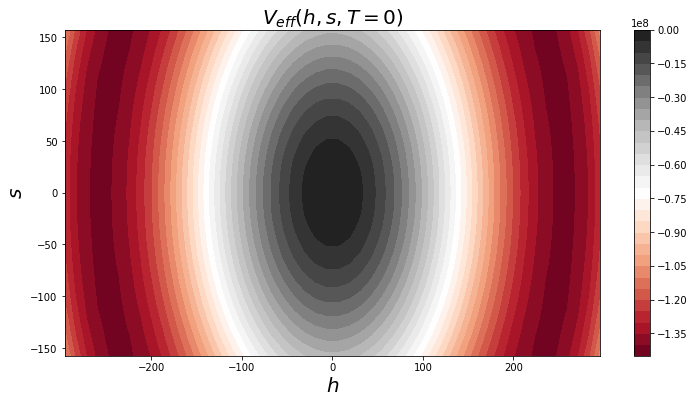

In [20]:
clevs=50
myN = 30
Temp=0
box=(-v-50,v+50,-m.f-50,m.f+50)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + ")",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)
#ax1.scatter(v,m.f)
#global_min=m.findMinimum([v,m.f],0)
#ax1.scatter(global_min[0],global_min[1])
plt.show()

In [21]:
nuc_dict=find_nucleation(m)
tntrans=my_find_Trans(m)

doing (-3, -3)
Tracing phase starting at x = [245.99999979 107.53405547] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
........................................................................................................................................................
Tracing phase starting at x = [-1.46947574e-06  3.46595537e+02] ; t = 91.47200612806623
Tracing minimum down
traceMinimum t0 = 91.472
...............................................
Tracing minimum up
traceMinimum t0 = 91.472
...........................................
Tracing phase starting at x = [2.60242979e-06 3.39146847e+02] ; t = 161.22457523048962
Tracing minimum down
traceMinimum t0 = 161.225
.............................
Tracing minimum up
traceMinimum t0 = 161.225
......................................................................................................................................................................................................................................................


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........

In [22]:
tntrans['Delta_rho'] = m.energyDensity(tntrans["high_vev"],tntrans["Tnuc"]) - m.energyDensity(tntrans["low_vev"],tntrans["Tnuc"])
alpha=alpha_GW(tntrans["Tnuc"],tntrans['Delta_rho'])

Tn=tntrans["Tnuc"]
dS_TdT=gradAT(Tn,S_profile,eps=0.01,order=6)
beta=Tn*dS_TdT


In [23]:
beta,alpha,Tn,g_star(Tn)

(11010.375546573525,
 0.02858242859321392,
 69.11752351547817,
 array(97.56156493))

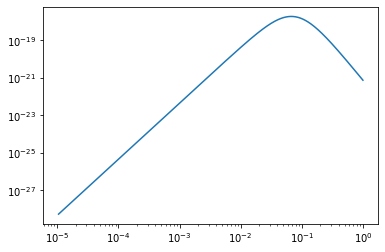

In [31]:
vwall=1
SNR=SNR_GW(Tn,alpha,beta,vwall)
my_signal=GW_signal(Tn,alpha,beta,vwall)
peak_vals=my_signal.T[my_signal[1]==max(my_signal[1])][0] ##Extract values at peak
f_peak=peak_vals[0]
Omega_peak=peak_vals[1]

plt.plot(my_signal[0],my_signal[1])
plt.xscale("log")
plt.yscale("log")

In [58]:
df=pd.read_csv("./SCANS/transitions_up_All.csv",index_col=[0]).sort_values("alpha")

my_dicts=[]
for nmod in range(0,len(df)):
    charges_path="./SCANS/Yukawa_fit_up_" + str(df.iloc[nmod].charge) + ".npy"
    best_fit.x=np.load(charges_path)
    print("Testing model ",nmod)
    m=model1(ms=  df.iloc[nmod].ms , theta= df.iloc[nmod].theta  ,fs= df.iloc[nmod].f )
    m.print_couplings()
    isglobal=m.global_min()
    theory_cons=m.theoretical_requirement()
    try:
        nuc_dict=find_nucleation(m)
        tntrans=my_find_Trans(m)
        dict_output={"ms":m.ms,"theta":m.theta,"f":m.f,"Mf":m.Mf,
                     "lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,
                     "muh2":m.muh,"mus2":m.mus,
                     "Tmin":nuc_dict["Tmin"],"Tmax":nuc_dict["Tmax"]}  
        Tn=tntrans["Tnuc"]
        dict_output["Tnuc"]=tntrans["Tnuc"]
        dict_output["h_low"]=tntrans["low_vev"][0]
        dict_output["h_high"]=tntrans["high_vev"][0]
        dict_output["s_low"]=tntrans["low_vev"][1]
        dict_output["s_high"]=tntrans["high_vev"][1]
        tntrans['Delta_rho'] = m.energyDensity(tntrans["high_vev"],tntrans["Tnuc"]) - m.energyDensity(tntrans["low_vev"],tntrans["Tnuc"])
        dict_output["alpha"]=alpha_GW(tntrans["Tnuc"],tntrans['Delta_rho'])
        dS_TdT=gradAT(Tn,S_profile,eps=0.01,order=6)
        beta=Tn*dS_TdT
        alpha=dict_output["alpha"]
        dict_output["beta"]=beta
        dict_output["dT"]=dict_output["Tmax"]-dict_output["Tmin"]
        dict_output["dPhi"]=np.sum((tntrans["low_vev"]-tntrans["high_vev"])**2)**0.5
        vwall=1
        SNR=SNR_GW(Tn,alpha,beta,vwall)
        my_signal=GW_signal(Tn,alpha,beta,vwall)
        peak_vals=my_signal.T[my_signal[1]==max(my_signal[1])][0] ##Extract values at peak
        f_peak=peak_vals[0]
        Omega_peak=peak_vals[1]
        dict_output.update({ "SNR_Tnuc": SNR,"f_peak":f_peak,"Omega_peak":Omega_peak})
        my_dicts.append(dict_output)
    except:
        continue
        
        

Testing model  0
The tree level couplings are given by 

mu_h=  9625.030111313707  mu_s= -774.7066440147952  lam_hs= 0.01811311846484259  lam_s= 0.0010506209684512996  lam_h= 0.12676564186424738 

The parameters of the model are 

ms=  13.075892976189651  theta= 0.13557090574823238  f= 464.45662078514437 

Global minimum found at  [246.         464.45662079]
The model is theoretically consistent True
doing (-3, -3)
Tracing phase starting at x = [245.99999847 464.45663045] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................................................................................................................................................................................................................................
Tracing phase starting at x = [-2.23158102e-05  8.53580830e+02] ; t = 107.6798214623213
Tracing minimum down
traceMinimum t0 = 107.68
........................................................
Tracing minimum up
traceMinimum t0 


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........

Path deformation converged. 1 steps. fRatio = 2.41376e-04
Tunneling from phase 1 to phase 0 at T=82.17391
high_vev = [1.47153018e-04 6.79963054e+02]
low_vev = [ 64.66341227 662.30023409]
Path deformation converged. 21 steps. fRatio = 1.32597e-02
Path deformation converged. 7 steps. fRatio = 1.92918e-02
Path deformation converged. 1 steps. fRatio = 3.76773e-03
Tunneling from phase 1 to phase 0 at T=82.25207
high_vev = [1.81807317e-04 6.79958829e+02]
low_vev = [ 58.98365853 665.29096419]
Path deformation converged. 24 steps. fRatio = 1.47216e-02
Path deformation converged. 6 steps. fRatio = 7.15122e-03
Path deformation converged. 1 steps. fRatio = 8.13761e-04
Tunneling from phase 1 to phase 0 at T=82.29116
high_vev = [2.06216823e-04 6.79956708e+02]
low_vev = [ 55.4516744  667.00732369]
Path deformation converged. 21 steps. fRatio = 1.36799e-02
Path deformation converged. 10 steps. fRatio = 5.51756e-03
Path deformation converged. 1 steps. fRatio = 3.87330e-04
Tunneling from phase 1 to pha


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

..........................
Tracing minimum up
traceMinimum t0 = 103.504
.......................................
Tracing phase starting at x = [5.95640215e-06 3.18547041e+02] ; t = 173.3893608475956
Tracing minimum down
traceMinimum t0 = 173.389
...........................
Tracing minimum up
traceMinimum t0 = 173.389
.......................................................................................................................................................................................................................................................................................................................................................................................................................
Tracing phase starting at x = [3.04232267e-06 9.68727310e+01] ; t = 576.6946210434212
Tracing minimum down
traceMinimum t0 = 576.695
.............................................................................................................................................

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ............

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 27 steps. fRatio = 1.23204e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Path deformation converged. 8 steps. fRatio = 6.64564e-03
Path deformation converged. 1 steps. fRatio = 9.17788e-04


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


Tunneling from phase 1 to phase 0 at T=55.61192
high_vev = [161.76480183 787.07236453]
low_vev = [213.95298726 571.73792095]
Path deformation converged. 22 steps. fRatio = 1.51913e-02
Path deformation converged. 8 steps. fRatio = 1.10577e-02
Path deformation converged. 1 steps. fRatio = 6.98096e-04
Tunneling from phase 1 to phase 0 at T=55.61427
high_vev = [161.13168284 789.04549071]
low_vev = [213.93610488 571.82771429]
Path deformation converged. 20 steps. fRatio = 1.35251e-02
Path deformation converged. 6 steps. fRatio = 1.97065e-02
Path deformation converged. 1 steps. fRatio = 5.20811e-03
Tunneling from phase 1 to phase 0 at T=55.77281
high_vev = [151.31769506 818.04867425]
low_vev = [212.7191459  578.25968809]
Path deformation converged. 24 steps. fRatio = 1.93444e-02
Path deformation converged. 8 steps. fRatio = 8.07093e-03
Path deformation converged. 1 steps. fRatio = 9.80121e-04
Tunneling from phase 1 to phase 0 at T=55.61477
high_vev = [161.02339479 789.3816889 ]
low_vev = [21

Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Deformation doesn't appear to be converging.Stopping at the point of best convergence.
Maximum number of deformation iterations reached.
Tunneling from phase 2 to phase 0 at T=81.23951
high_vev = [1.28866995e-05 1.16610205e+03]
low_vev = [ 122.05743304 1032.56698463]
Path deformation converged. 36 steps. fRatio = 1.60473e-02
Path deformation converged. 15 steps. fRatio = 1.97373e-02
Path deformation converged. 1 steps. fRatio = 7.61067e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:259: RuntimeWarning: overflow encountered in multiply
  y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/Mphys) + 1e-100)
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:260: RuntimeWarning: overflow encountered in multiply
  - 1.5)  + 2*n*m2*Mphys, axis=-1)


Tunneling from phase 2 to phase 0 at T=81.24001
high_vev = [1.54954415e-05 1.16610200e+03]
low_vev = [ 122.04140967 1032.60382869]
Path deformation converged. 36 steps. fRatio = 1.60318e-02
Path deformation converged. 15 steps. fRatio = 1.95996e-02
Path deformation converged. 1 steps. fRatio = 7.60129e-02
Tunneling from phase 2 to phase 0 at T=81.5816
high_vev = [1.60904474e-05 1.16607454e+03]
low_vev = [ 108.95808967 1060.76782497]
Path deformation converged. 36 steps. fRatio = 1.94310e-02
Path deformation converged. 15 steps. fRatio = 1.78464e-02
Path deformation converged. 1 steps. fRatio = 7.25019e-02
Tunneling from phase 2 to phase 0 at T=81.75239
high_vev = [-2.87776861e-05  1.16606072e+03]
low_vev = [  99.84295722 1078.2004879 ]
Path deformation converged. 30 steps. fRatio = 1.99655e-02
Path deformation converged. 19 steps. fRatio = 1.33000e-02
Path deformation converged. 1 steps. fRatio = 6.93796e-02
Tunneling from phase 2 to phase 0 at T=81.58549
high_vev = [6.79402912e-06 1.1

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

.....................................................................................................................................................................................................................................................................................................
Tracing phase starting at x = [ 50.42732079 917.89976924] ; t = 55.082518054879095
Tracing minimum down
traceMinimum t0 = 55.0825
...................................................................................................
Tracing minimum up
traceMinimum t0 = 55.0825
........................................................
Tracing phase starting at x = [9.50738598e-06 9.38134407e+02] ; t = 58.66406604356401
Tracing minimum down
traceMinimum t0 = 58.6641
.........................
Tracing minimum up
traceMinimum t0 = 58.6641


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........


 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ................. 

 ...........

Path deformation converged. 33 steps. fRatio = 1.86687e-02
Path deformation converged. 14 steps. fRatio = 1.48826e-02
Path deformation converged. 1 steps. fRatio = 7.38453e-02
Tunneling from phase 1 to phase 0 at T=68.34089
high_vev = [-5.38726885e-05  3.47828007e+02]
low_vev = [238.61513607 107.56784115]
Path deformation converged. 22 steps. fRatio = 1.93333e-02
Path deformation converged. 16 steps. fRatio = 1.09976e-02
Path deformation converged. 7 steps. fRatio = 8.12930e-03
Path deformation converged. 1 steps. fRatio = 4.54543e-04
Tunneling from phase 1 to phase 0 at T=69.47411
high_vev = [1.32264573e-05 3.47783472e+02]
low_vev = [238.07687076 107.88356614]
Path deformation converged. 26 steps. fRatio = 1.81002e-02
Path deformation converged. 14 steps. fRatio = 1.59355e-02
Path deformation converged. 6 steps. fRatio = 1.55474e-02
Path deformation converged. 1 steps. fRatio = 3.29526e-03
Tunneling from phase 1 to phase 0 at T=69.00886
high_vev = [6.84919010e-07 3.47802021e+02]
low_v

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Path deformation converged. 55 steps. fRatio = 1.62582e-02
Path deformation converged. 32 steps. fRatio = 1.59785e-02
Path deformation converged. 13 steps. fRatio = 1.32400e-02
Path deformation converged. 1 steps. fRatio = 3.53497e-02
Tunneling from phase 2 to phase 4 at T=56.96334
high_vev = [-1.50860751e-04  7.36115743e+02]
low_vev = [109.48110956 663.55940769]
Path deformation converged. 23 steps. fRatio = 1.85218e-02
Path deformation converged. 14 steps. fRatio = 1.19512e-02
Path deformation converged. 1 steps. fRatio = 5.53204e-02
Tunneling from phase 2 to phase 4 at T=57.38002
high_vev = [6.78062836e-06 7.36094688e+02]
low_vev = [102.02806026 672.91972016]
Path deformation converged. 20 steps. fRatio = 1.36112e-02
Path deformation converged. 13 steps. fRatio = 1.61392e-02
Path deformation converged. 1 steps. fRatio = 2.21295e-02
Tunneling from phase 2 to phase 4 at T=57.36168
high_vev = [-1.88963395e-06  7.36095608e+02]
low_vev = [102.40270819 672.46668136]
Path deformation conve

In [35]:
def Hubble_vacuum(T):
    """Hubble parameter for matter density alone. Second term in formula 2.6 of 1809.08242 """
    if m.phases is None:
        phases_dict=m.getPhases()
    else:
        phases_dict=m.phases
    if T<nuc_dict["Tmin"] or T>nuc_dict["Tmax"]:
        return 0
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Delta_V=0.0
    for tran_barrier in crit_temps:
        if tran_barrier["trantype"] ==2:
            continue
        ###LOOKS FOR TWO-STEP TRANSITIONS
        elif T>tran_barrier["Tcrit"] or ((abs(tran_barrier["high_vev"][0]-tran_barrier["low_vev"][0])<10) and (abs(tran_barrier["high_vev"][1]-tran_barrier["low_vev"][1])<10)):
            continue
        else:
            V_high=m.Vtot(phases_dict[tran_barrier["high_phase"]].valAt(T),T)
            V_low=m.Vtot(phases_dict[tran_barrier["low_phase"]].valAt(T),T)
            if V_high>V_low: 
                Delta_V += V_high - V_low

    return (Delta_V/3)**0.5/Mplanck


def Hubble_total(T):
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return (Hubble_rad_squared+Hubble_vacuum(T)**2)**0.5


def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**3
    return Gamma1
    

##DEFINE ACTION FUNCTION
def my_Action(T):
    """Calculates S/T at T"""
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                              dV=m.gradV, phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: S/T ,
                              fullTunneling_params={}, verbose=True, outdict={})
    except:
        S=np.inf
    return S


    
##DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
def nucleation_temp(T):
    """DEFINE Nucleation FUNCTION (TO BE OPTIMIZED)
    """
    from cosmoTransitions import transitionFinder as tf
    try:
        S=tf._tunnelFromPhaseAtT(T=T, phases=m.phases, start_phase=m.phases[nuc_dict["high_phase"]], V=m.Vtot, 
                                  dV=m.gradV,phitol=1e-15, overlapAngle=45, nuclCriterion=lambda S,T: Gamma_Hubble4(S,T)-Hubble_total(T)**4,
                                  fullTunneling_params={}, verbose=True, outdict={})
    except:
        return 1e+100
    
    if np.isnan(S):
        return 1e+100
    else:
        return S**2
    
Tnuc=optimize.fmin(nucleation_temp,(nuc_dict["Tmin"]+nuc_dict["Tmax"])*0.5,xtol=0.0001)
S_nuc=my_Action(Tnuc)

Tunneling from phase 2 to phase 0 at T=268.6795
high_vev = [ 43.93105958 561.69251932]
low_vev = [ 95.17134096 551.04746673]
Path deformation converged. 11 steps. fRatio = 1.88406e-02
Path deformation converged. 4 steps. fRatio = 1.77886e-02
Path deformation converged. 1 steps. fRatio = 1.85029e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:260: RuntimeWarning: overflow encountered in multiply
  - 1.5)  + 2*n*m2*Mphys, axis=-1)
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:259: RuntimeWarning: overflow encountered in multiply
  y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/Mphys) + 1e-100)
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=270.3587
high_vev = [ 29.11517419 563.58536916]
low_vev = [ 86.80131697 553.49653765]
Path deformation converged. 14 steps. fRatio = 1.51901e-02
Path deformation converged. 1 steps. fRatio = 2.97152e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:260: RuntimeWarning: overflow encountered in multiply
  - 1.5)  + 2*n*m2*Mphys, axis=-1)
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/generic_potential_1.py:259: RuntimeWarning: overflow encountered in multiply
  y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/Mphys) + 1e-100)
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/scipy/optimize/optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=269.5191
high_vev = [ 37.53269772 562.59871195]
low_vev = [ 91.29167978 552.21503404]
Path deformation converged. 15 steps. fRatio = 1.35831e-02
Path deformation converged. 1 steps. fRatio = 3.68434e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=269.9389
high_vev = [ 33.68993872 563.07824128]
low_vev = [ 89.14209796 552.83788077]
Path deformation converged. 14 steps. fRatio = 1.78705e-02
Path deformation converged. 1 steps. fRatio = 3.52488e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=270.1488
high_vev = [ 31.51586422 563.32796465]
low_vev = [ 87.99902922 553.16206788]
Path deformation converged. 12 steps. fRatio = 3.07239e-03
Path deformation converged. 1 steps. fRatio = 1.83960e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=270.2538
high_vev = [ 30.34720309 563.45569395]
low_vev = [ 87.40754394 553.32792277]
Path deformation converged. 14 steps. fRatio = 1.49934e-02
Path deformation converged. 1 steps. fRatio = 2.54304e-02


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


Tunneling from phase 2 to phase 0 at T=270.3063
high_vev = [ 29.73956702 563.52029533]
low_vev = [ 87.10631155 553.4118825 ]
Path deformation converged. 14 steps. fRatio = 1.51134e-02
Path deformation converged. 1 steps. fRatio = 2.83570e-02
Tunneling from phase 2 to phase 0 at T=270.2538
high_vev = [ 30.34720309 563.45569395]
low_vev = [ 87.40754394 553.32792277]
Path deformation converged. 14 steps. fRatio = 1.49934e-02
Path deformation converged. 1 steps. fRatio = 2.54304e-02
Tunneling from phase 2 to phase 0 at T=270.3325
high_vev = [ 29.42961282 563.55276534]
low_vev = [ 86.95432862 553.45410113]
Path deformation converged. 14 steps. fRatio = 1.51652e-02
Path deformation converged. 1 steps. fRatio = 2.85067e-02
Tunneling from phase 2 to phase 0 at T=270.28
high_vev = [ 30.04542683 563.48792671]
low_vev = [ 87.25745631 553.36978935]
Path deformation converged. 14 steps. fRatio = 1.50528e-02
Path deformation converged. 1 steps. fRatio = 2.67909e-02
Tunneling from phase 2 to phase 0 

Path deformation converged. 14 steps. fRatio = 1.50283e-02
Path deformation converged. 1 steps. fRatio = 2.57176e-02


In [40]:
m.phases=my_phases={nuc_dict["low_phase"]:m.phases[nuc_dict["low_phase"]],nuc_dict["high_phase"]:m.phases[nuc_dict["high_phase"]],}
#m.findAllTransitions(tunnelFromPhase_args={"Ttol":0.0001,"phitol":1e-08,"nuclCriterion":lambda S,T: S/(T+1e-100)-S_nuc})
m.findAllTransitions(tunnelFromPhase_args={"nuclCriterion":lambda S,T: S/(T+1e-100)-S_nuc})



Tunneling from phase 0 to phase 2 at T=271.5504
high_vev = [ 78.21120727 555.73692842]
low_vev = [4.83759968e-01 5.65089521e+02]
Path deformation converged. 15 steps. fRatio = 1.62294e-02
Path deformation converged. 1 steps. fRatio = 7.72295e-02
Tunneling from phase 0 to phase 2 at T=271.5499
high_vev = [ 78.21597721 555.73575598]
low_vev = [  0.71063266 565.08904338]
Path deformation converged. 15 steps. fRatio = 1.59980e-02
Path deformation converged. 1 steps. fRatio = 7.63585e-02
Tunneling from phase 0 to phase 2 at T=271.5494
high_vev = [ 78.2207362 555.7345894]
low_vev = [  0.88401222 565.08858585]
Path deformation converged. 15 steps. fRatio = 1.59815e-02
Path deformation converged. 1 steps. fRatio = 7.85745e-02
Tunneling from phase 0 to phase 2 at T=271.5489
high_vev = [ 78.22551449 555.73342921]
low_vev = [  1.02822792 565.08810152]
Path deformation converged. 15 steps. fRatio = 1.56856e-02
Path deformation converged. 1 steps. fRatio = 7.66575e-02
Tunneling from phase 0 to phas

[{'low_vev': array([ 25.54888451, 563.93165033]),
  'high_vev': array([ 85.14809791, 553.94937337]),
  'Tnuc': 270.6314379587639,
  'low_phase': 2,
  'high_phase': 0,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.        , 0.00228854, 0.00457078, 0.00684672, 0.00911636,
         0.01137969, 0.01363672, 0.01588745, 0.01813187, 0.02036999,
         0.02260181, 0.02482733, 0.02704654, 0.02925946, 0.03146607,
         0.03366637, 0.03586038, 0.03804808, 0.04022948, 0.04240457,
         0.04457337, 0.04673586, 0.04889205, 0.05104193, 0.05318551,
         0.0553228 , 0.05745377, 0.05957845, 0.06169682, 0.06380889,
         0.06591466, 0.06801413, 0.07010729, 0.07219415, 0.0742747 ,
         0.07634896, 0.07841691, 0.08047856, 0.08253391, 0.08458295,
         0.08662569, 0.08866213, 0.09069227, 0.0927161 , 0.09473363,
         0.09674486, 0.09874979, 0.10074841, 0.10274073, 0.10472675,
         0.10670647, 0.10867988, 0.11064699, 0.1126078 , 0.11456231,
         0.11651051,

In [42]:
m.phases

{0: Phase(key=0, X=[[246 457.2], ..., [68.39 557.9]], T=[0, ..., 272.1], dXdT=[[-0 0], ..., [-184.4 37.73]],
 2: Phase(key=2, X=[[54.77 559.8], ..., [0.4838 565.1]], T=[266.9, ..., 271.6], dXdT=[[-6.994 1.295], ..., [-5.85 -0.1733]]}